# Imports

In [1]:
import numpy as np
from unicodedata import normalize
from pprint import pprint
import string
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, TimeDistributed, RepeatVector  # CuDNNLSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Reading movie lines

In [3]:
table = str.maketrans('', '', string.punctuation)
# prepare regex for char filtering
re_print = re.compile('[^%s]' % re.escape(string.printable))
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

def clean_sentence(line):
    line = line.strip().replace('--', '').replace("  ", " ").replace('"', "")
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    # tokenize on white space
    line = line.split()
    # convert to lowercase
    line = [word.lower() for word in line]
    # remove punctuation from each token
    line = [word.translate(table) for word in line]
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    # remove tokens with numbers in them
    line = [word for word in line if word.isalpha()]
    return ' '.join(line)

with open('./cornell-movie-dialogs-corpus/movie_lines.txt', 'r', errors='ignore') as f:
    lines_as_list = [row.strip() for row in f.readlines()]


lines = {}
for line in lines_as_list:
    lines[
        line.split('+++$+++')[0].strip()
    ] = clean_sentence(line.split('+++$+++')[-1])  # clean sentences

del lines_as_list

with open('./cornell-movie-dialogs-corpus/movie_conversations.txt', 'r', errors='ignore') as f:
    conversations = [row.strip() for row in f.readlines()]

# only take id's and convert list as string to list as list
conversations = [
    conversation.split('+++$+++')[-1].strip().replace('[', '').replace(']', '').replace("'", '').replace(" ", '').split(',') 
    for conversation in conversations
]

pprint({k: lines[k] for k in list(lines)[:10]})
print()
pprint(conversations[:10])

assert len([conversation for conversation in conversations if len(conversation) <=1]) == 0


{'L1044': 'they do to',
 'L1045': 'they do not',
 'L869': 'like my fear of wearing pastels',
 'L870': 'im kidding you know how sometimes you just become this persona and '
         'you dont know how to quit',
 'L871': 'no',
 'L872': 'okay youre gonna need to learn how to lie',
 'L924': 'wow',
 'L925': 'lets go',
 'L984': 'she okay',
 'L985': 'i hope so'}

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]


# map keys to line

In [4]:
conversations_with_lines = []
for conversation in conversations:
    conversations_with_lines.append([lines[key] for key in conversation])
    
pprint(conversations_with_lines[100:110])

[['yeah', 'what do you think'],
 ['two legs nice rack',
  'yeah whatever i want you to go out with her',
  'sure sparky ill get right on it',
  'you just said',
  'you need money to take a girl out',
  'but youd go out with her if you had the cake'],
 ['you got it verona i pick up the tab you do the honors',
  'youre gonna pay me to take out some girl',
  'i cant date her sister until that one gets a boyfriend and thats the catch '
  'she doesnt want a boyfriend',
  'how much'],
 ['i cant take a girl like that out on twenty bucks', 'fine thirty'],
 ['take it or leave it this isnt a negotiation',
  'fifty and youve got your man'],
 ['when i shell out fifty i expect results',
  'im on it',
  'watching the bitch trash my car doesnt count as a date',
  'i got her under control she just acts crazed in public to keep up the '
  'image'],
 ['i just upped my price',
  'what',
  'a hundred bucks a date',
  'forget it',
  'forget her sister then'],
 ['its about time', 'a deals a deal'],
 ['howd 

# Pair those things

In [5]:
def pair_it(my_list):
    pairs = []
    for i in range(len(my_list) -1):
        pairs.append([my_list[i], my_list[i + 1]])
    return pairs

paired_conversations_agg = [
    pair_it(conversation) for conversation in conversations_with_lines
]
conversations_pairs = np.array([item for sublist in paired_conversations_agg for item in sublist])
for i in range(10):
    pprint(conversations_pairs[i])

array(['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
       'well i thought wed start with pronunciation if thats okay with you'],
      dtype='<U2857')
array(['well i thought wed start with pronunciation if thats okay with you',
       'not the hacking and gagging and spitting part please'],
      dtype='<U2857')
array(['not the hacking and gagging and spitting part please',
       'okay then how bout we try out some french cuisine saturday night'],
      dtype='<U2857')
array(['youre asking me out thats so cute whats your name again',
       'forget it'], dtype='<U2857')
array(['no no its my fault we didnt have a proper introduction',
       'cameron'], dtype='<U2857')
array(['cameron',
       'the thing is cameron im at the mercy of a particularly hideous breed of loser my sister i cant date until she does'],
      dtype='<U2857')
array(['the thing is cameron im at the mercy of a particularly hideou

# Noise reduction

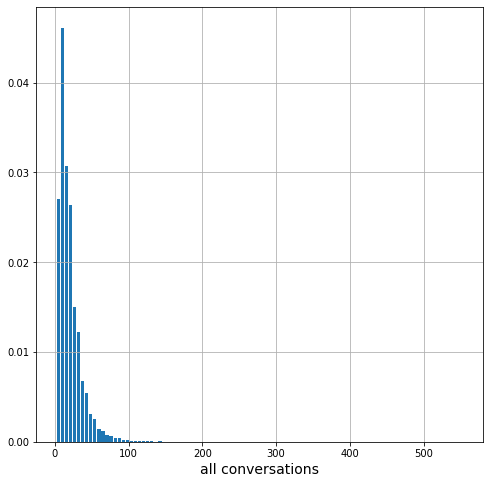

longest conversation: 
['what'
 'then lets begin with the story itself its a story of the grail mythand although there are several variations my favorite begins with the fisher king as a young boy who had to spend a night alone in the forest to prove his courage and during that night he is visited by a sacred vision out of the fire appears the holy grail gods highest symbol of divine grace and a voice says to the boy you shall be the guardian of the grail that it may heal the hearts of menbut the boy was overcome innocent and foolish he was blinded by greater visions a life ahead filled with beauty and glory hope and powertears filled his eyes as he sensed his own invincibility a boys tears of naive wonder and inspiration and in this state ofradical amazementhe felt for a brief moment not like a boy but like god and so he reached into the fire to take the grail and the grail vanished and the boy hands were left caught in the flamesleaving him wounded and ashamed at what his recklessnes

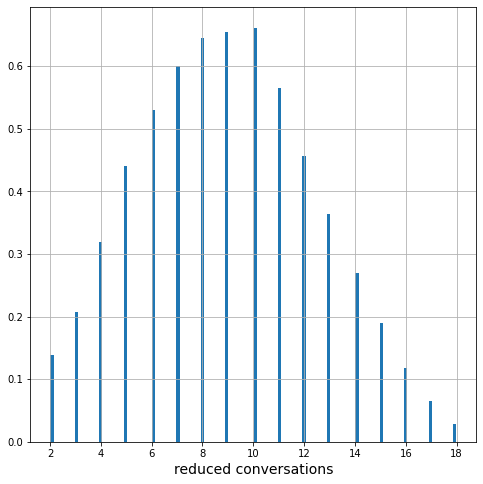

longest conversation in reduce dataset: 
['do you really want me to forget about you'
 'i dont want to drag you down with me']

longest conversation in reduce dataset has 18 words.


In [6]:
hist, edges  = np.histogram([len(question.split(' ')) + len(answer.split(' ')) for question, answer in conversations_pairs], density=True, bins=100)
center = (edges[:-1] + edges[1:]) / 2
f, ax = plt.subplots(figsize=(8, 8))
plt.xlabel('all conversations', fontsize=14)
plt.bar(center, hist, align='center', width=(edges[1] - edges[0]) * .8)
plt.grid()
plt.show()

longest_converastion = conversations_pairs[np.array([len(question.split(' ')) + len(answer.split(' ')) for question, answer in conversations_pairs]).argmax()]
print("longest conversation: \n{}\n".format(longest_converastion))
print("longest conversation has {} words.".format(len(longest_converastion[0].split(' ')) + len(longest_converastion[1].split(' '))))
max_sentence_lenght = 10  # maximum alowed converastion lenght in words
clensed_conversations = np.array([conversation_pair for conversation_pair in conversations_pairs  if len(conversation_pair[0].split(' ')) < max_sentence_lenght and len(conversation_pair[1].split(' '))  < max_sentence_lenght ])
print("filetered {} conversations\n".format(len(conversations_pairs) - len(clensed_conversations)))

hist, edges  = np.histogram([len(question.split(' ')) + len(answer.split(' ')) for question, answer in clensed_conversations], density=True, bins=100)
center = (edges[:-1] + edges[1:]) / 2
f, ax = plt.subplots(figsize=(8, 8))
plt.bar(center, hist, align='center', width=(edges[1] - edges[0]) * .8)
plt.xlabel('reduced conversations', fontsize=14)
plt.grid()
plt.show()
longest_converastion = clensed_conversations[np.array([len(question.split(' ')) + len(answer.split(' ')) for question, answer in clensed_conversations]).argmax()]
print("longest conversation in reduce dataset: \n{}\n".format(longest_converastion))
print("longest conversation in reduce dataset has {} words.".format(len(longest_converastion[0].split(' ')) + len(longest_converastion[1].split(' '))))

del paired_conversations_agg 
del conversations_pairs

# Shity magic

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clensed_conversations.reshape(-1))
vocabulary = np.fromiter(tokenizer.word_index.keys(), dtype="<U34")
all_lines = clensed_conversations.reshape(-1)

max_sentence_lenght = max(len(line.split()) for line in all_lines)
print("first word: {}, last word: {}".format(vocabulary[0], vocabulary[-1]))
print('max sentence lenght: {} words'.format(max_sentence_lenght))
print('vocab_size: {} words'.format(len(vocabulary)))

assert len(vocabulary) < 65535
input_data = np.zeros((len(clensed_conversations), max_sentence_lenght), dtype='uint16')
output_data = np.zeros((len(clensed_conversations), max_sentence_lenght, len(vocabulary)), dtype='uint8')

with tqdm(total=len(clensed_conversations)) as pbar:
    for i, (left, right) in enumerate(clensed_conversations):
        for t, (word) in enumerate(left.split()):
            input_data[i, t] = np.where(vocabulary == word)[0][0]
        for t, (word) in enumerate(right.split()):
            output_data[i, t, np.where(vocabulary == word)[0][0]] = 1
        pbar.update(1)


first word: you, last word: explaining
max sentence lenght: 9 words
vocab_size: 26968 words


# Define Model
![sequential](./images/sequential.jpg)

In [8]:
K.clear_session()

n_units=1024
model = Sequential()
model.add(Embedding(input_dim=len(vocabulary), output_dim=n_units, input_length=max_sentence_lenght, mask_zero=True))
model.add(LSTM(units=n_units))
model.add(RepeatVector(max_sentence_lenght))
model.add(LSTM(units=n_units))
model.add(RepeatVector(max_sentence_lenght))
model.add(LSTM(units=n_units))
model.add(RepeatVector(max_sentence_lenght))
model.add(LSTM(units=n_units, return_sequences=True))
model.add(TimeDistributed(Dense(len(vocabulary), activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# summarize defined model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9, 1024)           27615232  
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              8392704   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 9, 1024)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 9, 1024)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 9, 1024)           0

# Training

In [ ]:
epochs=30
batch_size=16

# config = tf.compat.v1.ConfigProto()
# # dynamically grow the memory used on the GPU
# config.gpu_options.allow_growth = True  
# # to log device placement (on which device the operation ran)(nothing gets printed in Jupyter, only if you run it standalone)
# config.log_device_placement = True    
# sess = tf.compat.v1.Session(config=config)
# set_session(sess)

filename = 'mount-this/sequential-model.h5'
checkpoint = ModelCheckpoint(filename, monitor='accuracy', verbose=1, save_best_only=True, mode='min')
model.fit(input_data, output_data, epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=1, validation_split=0.2)


In [ ]:
model = load_model("mount-this/model.h5")

In [ ]:
to_infer = "how are you"
source = np.zeros(max_sentence_lenght)

for i in range(len(to_infer.split())):
    source[i] = np.where(vocabulary == to_infer.split()[i])[0][0]
source = source.reshape((1, source.shape[0]))
res = model.predict(source)
sentence = " ".join([vocabulary[np.argmax(word_indexes)] for word_indexes in res[0] if np.max(word_indexes) > .2])
sentence